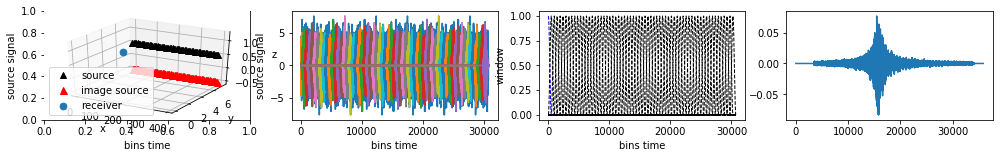

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


# sound speed
c = 344.0
# density kg.m^-3
rho = 1.2

# greens function
def greens(d,t,T0):
        #initialize the green function in time domain
        g = np.zeros(len(t))
        # propagation time direct wave
        tau = d / c
        # match = correspondence index of times ts(index) in time axis t
        match = np.argmin( np.abs( t - tau - T0) )
        g[match] = rho / (4 * np.pi * d)
        return g


FrequenciesRandon = np.arange(20,1024*2*2)
wave_frequency = np.random.choice(FrequenciesRandon,10)
wave_amplitude = 1

sample_rate = 1024*5 # samples per sec (rule of thumb is at least 2x the cut off frequency) avoi aliasing
total_sampling_time = 6 # s
num_samples = sample_rate * total_sampling_time

sample_time_array = np.arange(0, total_sampling_time, 1/sample_rate)

# signal generator
fun = lambda x: np.sum( wave_amplitude * np.sin(wave_frequency * 2*np.pi * x))
source_signal = [fun(i) for i in sample_time_array]


# receiver and source heights
zr = 1.2
zs = 0.5

#horizontal distance receiver source plane
yd = 7.5

# hanning windows for each position
# moving source velocity, vehicle velocity, constant velocity
vs = 40 #m/s

# time discretizations t[j] - moving source i decided for a 1s discretization
tf = 10 #s
num_points = 64
time_discretization = tf/num_points
t = np.arange(0, tf, time_discretization)

# distance travelled - source moving straight line over the receiver, moving coordinate
x = np.linspace(0, tf * vs, num_points, endpoint=False) # discretized points
y = yd * np.ones(num_points)
z = zs * np.ones(num_points)

position_source = np.vstack((x, y, z)).T

position_receiver = np.array([x.max()/2.0, 0.0, zr])

prop_distance = np.linalg.norm((position_source - position_receiver), axis=-1)

adjust_axis = num_samples / num_points
size_window = ( adjust_axis ) * 2
w = np.hanning(size_window)

#  pulse (impulse response starts at T0)
T0 = .1 #s
Tp = 1.0 #s
IR_time_array = np.arange(0, Tp, 1/sample_rate)

fig, (ax, ax1,ax2, ax3)= plt.subplots(1,4, figsize=(17,2))
ax1.plot(source_signal)
ax1.set(xlabel='bins time', ylabel='source signal')

receiver_signal = np.zeros(len(IR_time_array) + num_samples - 1 )

for ii in range(num_points):
    if ii == 0:
        wpad = np.pad( w, ( 0, int(num_samples - adjust_axis )), 'constant')
        wpad = wpad[int(adjust_axis):]
        source_signal_windowed = source_signal * wpad
        
        g  = greens(prop_distance[ii],IR_time_array,T0)
        receiver_signal += np.convolve(g, source_signal_windowed)
      
        ax2.plot(wpad,'b--', lw=1, label='hanning window' )
        ax1.plot(source_signal_windowed)
    else:
        wpad = np.pad( w, (  int(adjust_axis * (ii-1)), num_samples - int(adjust_axis * (ii+1)) ), 'constant')
        if len(wpad) > len(source_signal): wpad = wpad[:len(source_signal)]
        source_signal_windowed = source_signal * wpad
        
        g  = greens(prop_distance[ii],IR_time_array,T0)
        receiver_signal += np.convolve(g, source_signal_windowed)

        ax2.plot(wpad,'k--', lw=1, label='hanning window' )
        ax1.plot(source_signal_windowed)
        
ax.set(xlabel='bins time', ylabel='source signal')
ax2.set(xlabel='bins time', ylabel='window')

ax = fig.add_subplot(141, projection='3d')
ax.plot(x, y, z, 'k^')
ax.plot(x, y, -z, 'r^', ms=7)
ax.scatter(position_receiver[0],position_receiver[1],position_receiver[2],s=45)
ax.legend(['source', 'image source', 'receiver'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax3.plot(receiver_signal)

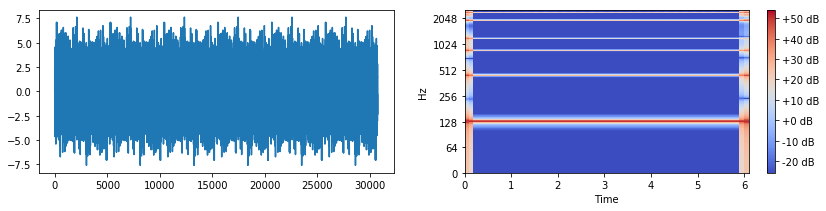

In [193]:
import librosa
import librosa.display
import IPython.display as ipd

fig, (ax,ax2)= plt.subplots(1,2, figsize=(14, 3))
ax.plot(source_signal)

X_signal = librosa.stft(np.array(source_signal))
Xdb_signal = librosa.amplitude_to_db(abs(X_signal))
librosa.display.specshow(Xdb_signal, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

# synthesized audio
ipd.Audio(source_signal, rate=sample_rate)

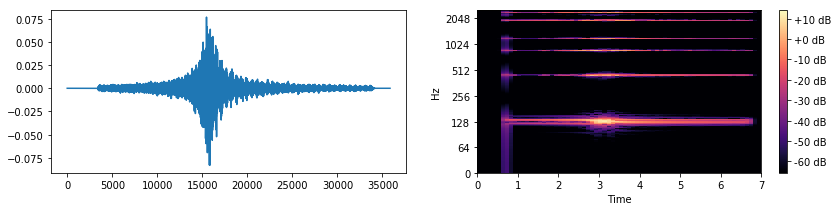

In [194]:
import librosa
import librosa.display
import IPython.display as ipd

fig, (ax,ax2)= plt.subplots(1,2, figsize=(14, 3))
ax.plot(receiver_signal)

X_signal = librosa.stft(receiver_signal)
Xdb_signal = librosa.amplitude_to_db(abs(X_signal))
librosa.display.specshow(Xdb_signal, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

# synthesized audio
ipd.Audio(receiver_signal, rate=sample_rate)